In [1]:
# model segformerb4 settings
from mmseg.models import build_segmentor
from mmcv.runner.optimizer import build_optimizer
import torch

def segformer():
    model = dict(
        type='SunSegmentor',
        backbone=dict(
            type='MixVisionTransformer',
            in_channels=3,
            embed_dims=64,
            num_stages=4,
            num_layers=[2, 2, 2, 2],
            num_heads=[1, 2, 5, 8],
            patch_sizes=[7, 3, 3, 3],
            sr_ratios=[8, 4, 2, 1],
            out_indices=(0, 1, 2, 3),
            mlp_ratio=4,
            qkv_bias=True,
            drop_rate=0.0,
            attn_drop_rate=0.0,
            drop_path_rate=0.1,
            pretrained="/mnt/sdd/nguyen.van.quan/BKAI-kaggle/pretrained/mit_b1_mmseg.pth"),
        decode_head=dict(
            type='UPerHeadV3',
            in_channels=[64, 128, 320, 512],
            in_index=[0, 1, 2, 3],
            channels=128,
            dropout_ratio=0.1,
            num_classes=1,
            norm_cfg=dict(type='BN', requires_grad=True),
            align_corners=False,
            loss_decode=dict(type='CrossEntropyLoss', use_sigmoid=True, loss_weight=1.0)),
        # model training and testing settings
        train_cfg=dict(),
        test_cfg=dict(mode='whole'))
    model = build_segmentor(model)
    model.init_weights()
    return model
    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad) / 1e6
model = segformer()
out = model(torch.rand((2, 3, 352, 352)))
for i in out:
    print(i.shape)

2022-08-26 00:12:00.727795: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
/mnt/sdd/nguyen.van.quan/Researchs/Polyp/mmseg/models/backbones/mit.py:365: UserWarning: DeprecationWarning: pretrained is deprecated, please use "init_cfg" instead
  warnings.warn('DeprecationWarning: pretrained is deprecated, '
/mnt/sdd/nguyen.van.quan/Researchs/Polyp/mmseg/models/losses/cross_entropy_loss.py:235: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(
/mnt/sdd/nguyen.van.quan/miniconda3/envs/pytorch/lib/python3.8/site-packages/mmcv/cnn/bricks/hsigmoid.py:36: UserWarning: In MMCV v1.4.4, we modified 

torch.Size([2, 1, 352, 352])
torch.Size([2, 1, 352, 352])
torch.Size([2, 1, 352, 352])
torch.Size([2, 1, 352, 352])
torch.Size([2, 1, 352, 352])


In [2]:
count_parameters(model)

18.139873

In [1]:
from mmseg.models.decode_heads.rcfpn import RCFPN
import torch
rfp = RCFPN([64, 128, 320, 512], 128, 5)
test1 = torch.rand((2, 64, 128, 128))
test2 = torch.rand((2, 128, 64, 64))
test3 = torch.rand((2, 320, 32, 32))
test4 = torch.rand((2, 512, 16, 16))

rfp_out = rfp([test1, test2, test3, test4])


2022-08-21 20:21:20.030016: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


4
4


In [2]:

from mmseg.models.decode_heads.lib.bifpn import *

bifpn = BiFPN([64, 128, 320, 512], 128)

test1 = torch.rand((2, 64, 128, 128))
test2 = torch.rand((2, 128, 64, 64))
test3 = torch.rand((2, 320, 32, 32))
test4 = torch.rand((2, 512, 16, 16))

bifpn_out = bifpn([test1, test2, test3, test4])
for i in bifpn_out:
    print(i.shape)


torch.Size([2, 128, 128, 128])
torch.Size([2, 128, 64, 64])
torch.Size([2, 128, 32, 32])
torch.Size([2, 128, 16, 16])
torch.Size([2, 128, 8, 8])


In [1]:
import torchvision.transforms as transforms
from mcode.custom_transform import *
import glob
train_transform = transforms.Compose([
    Random_dilation_erosion(),
    Random_flip(),
    Random_image_enhance(),
    Random_rotate(),
    Random_scale_crop(),
    Tonumpy(),
    Normalize(),
    Totensor(),
    
])

2022-08-26 00:54:33.377228: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [2]:
from torch.utils.data import Dataset, DataLoader

f_images = glob.glob('TrainDataset/image/*')
f_masks = glob.glob('TrainDataset/mask/*')

X_test = glob.glob('TestDataset/*/images/*')
y_test = glob.glob('TestDataset/*/masks/*')

# X_val = glob.glob('/content/TestDataset/ETIS-LaribPolypDB/images/*')
# y_val = glob.glob('/content/TestDataset/ETIS-LaribPolypDB/masks/*')

trainsize = 352

budget_size = 75

seed = 2022

device = 'cuda:0'
class ActiveDataset(Dataset):
    """
    dataloader for polyp segmentation tasks
    """
    def __init__(self, image_paths=[], gt_paths=[], trainsize=352, transform=None):
        self.trainsize = trainsize
        self.images = image_paths
        self.masks = gt_paths
        self.size = len(self.images)
        self.filter_files()
        self.transform = transform
        
    def __getitem__(self, index):
        image = self.rgb_loader(self.images[index])
        mask = self.binary_loader(self.masks[index])
        sample = {"image":image, "gt":mask}
        if self.transform is not None:
            transformed = self.transform(sample)
            image = transformed["image"]
            mask = transformed["gt"]
            
        sample = dict(image=image, mask=mask, image_path=self.images[index], mask_path=self.masks[index])
        
        return sample

    def filter_files(self):
        assert len(self.images) == len(self.masks)
        images = []
        masks = []
        for img_path, mask_path in zip(self.images, self.masks):
            img = Image.open(img_path)
            mask = Image.open(mask_path)
            if img.size == mask.size:
                images.append(img_path)
                masks.append(mask_path)
        self.images = images
        self.masks = masks
    
    def rgb_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f).resize((trainsize, trainsize), Image.BILINEAR)
            return np.array(img.convert('RGB'))

    def binary_loader(self, path):
        with open(path, 'rb') as f:
            img = Image.open(f).resize((trainsize, trainsize), Image.NEAREST)
            img = np.array(img.convert('L'))
            return img

    def __len__(self):
        return self.size

In [3]:


train_dataset = ActiveDataset(
    f_images, 
    f_masks, 
    trainsize=trainsize, 
    transform=train_transform
)


print(f"Train size: {len(train_dataset)}")




Train size: 1450


In [4]:
sample = train_dataset[10]

In [5]:
class UnNormalize(object):
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        """
        Args:
            tensor (Tensor): Tensor image of size (C, H, W) to be normalized.
        Returns:
            Tensor: Normalized image.
        """
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor
    
unorm = UnNormalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


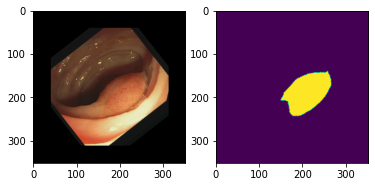

In [13]:
# lets look at some samples
from matplotlib import pyplot as plt
sample = train_dataset[10]


plt.subplot(1,2,1)
plt.imshow(unorm(sample["image"]).permute(1, 2, 0)) # for visualization we have to permute back to HWC
plt.subplot(1,2,2)
plt.imshow(sample["mask"].squeeze())  # for visualization we have to remove 3rd dimension of mask
plt.show()